### Table of Contents
* [Imports](#imports)
* [Prepare Dataset](#prepare-dataset)
    * [Load Dataset](#load-dataset)
    * [Analyse Dataset](#analyse-dataset)
    * [Preprocess Dataset](#preprocess-dataset)
* [Training Pipeline](#train-pipeline)
* [Training](#training)
* [Evaluation](#evaluation)
    * [External Evaluation](#external-evaluation)
* [Acknowledgements](#acknowledgements)

<a name="imports"></a>
# Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import (Layer, Input, Flatten,
                          Conv2D, MaxPool2D,
                          BatchNormalization, Dense, Dropout,
                          RandomFlip, RandomRotation, RandomZoom)
from keras import layers

import numpy as np
import matplotlib.pyplot as plot
import csv
import pandas as pd
from astropy.io import fits

import os
import warnings
import pdb

In [4]:
### Set Numpy Print Options ###
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [5]:
### Set random seed for reproducibility ###
SEED = 1
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [6]:
PERFORM_TRAINING = False # Set to False if only inference is to be done

<a name="prepare-dataset"></a>
# Prepare Dataset

<a name="load-dataset"></a>
### Load Dataset

In [7]:
# Unzip data
!tar zxf ./drive/MyDrive/test_3.tgz --transform s/lens_data/data/

In [8]:
DATAPATH = './data' # Root path of data
OUTPATH = './output' # Storing output
os.makedirs(OUTPATH, exist_ok=True)
SAVEPATH = os.path.join(OUTPATH, 'weights') # For storing model weights
os.makedirs(SAVEPATH)
CKP_PATH = os.path.join(SAVEPATH, 'ckp')

# Print directory structure
!tree --filelimit=10

.
├── data [20000 entries exceeds filelimit, not opening dir]
└── output
    └── weights

3 directories, 0 files


In [9]:
# Unzip model weights (if available)
!unzip -oq {os.path.join(OUTPATH, 'test_3_weights.zip')} -d {OUTPATH}

unzip:  cannot find or open ./output/test_3_weights.zip, ./output/test_3_weights.zip.zip or ./output/test_3_weights.zip.ZIP.


In [10]:
def load_data(root, use_cached=True):
    if use_cached:
        try:
            x = np.load(os.path.join(root, 'X.npy'))
            y = np.load(os.path.join(root, 'Y.npy'))
            return x, y
        except FileNotFoundError as _:
            warnings.warn('Cached data does not exist! Loading from raw data.')
    
    x, y = [], []
    for filename in os.scandir(root):
        temp = np.load(filename.path, allow_pickle=True)
        if len(temp) != 2:
            continue
        x_temp, y_temp = temp[0], temp[1]
        x.append(x_temp)
        y.append(y_temp)
  
    x = np.expand_dims(np.stack(x, axis=0), axis=-1) # Add channel axis
    y = np.stack(y, axis=0)

    np.save(os.path.join(root, 'X.npy'), x)
    np.save(os.path.join(root, 'Y.npy'), y)

    return x, y

In [11]:
X, Y = load_data(DATAPATH, use_cached=True)

print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {Y.shape}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Cached data does not exist! Loading from raw data.
  


Shape of X: (20000, 150, 150, 1)
Shape of Y: (20000,)


In [12]:
# Shuffle train data
perm = np.random.permutation(len(X))
X, Y = X[perm], Y[perm]

# Train / Val split
val_size = len(X) // 10
X_TRAIN, Y_TRAIN = X[val_size:], Y[val_size:]
X_VAL, Y_VAL = X[:val_size], Y[:val_size]

print(f'X_TRAIN shape: {X_TRAIN.shape}')
print(f'X_VAL shape: {X_VAL.shape}')

X_TRAIN shape: (18000, 150, 150, 1)
X_VAL shape: (2000, 150, 150, 1)


<a name="analyse-dataset"></a>
### Analyse Dataset

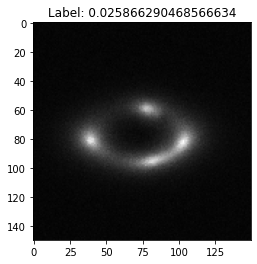

In [13]:
# Display random instance of data (This won't affect original SEED progression)
idx = np.random.default_rng().integers(0, len(X_TRAIN))
_ = plot.imshow(X_TRAIN[idx].squeeze(), cmap='gray')
_ = plot.title(f'Label: {Y_TRAIN[idx]}')

<a name="preprocess-dataset"></a>
### Preprocess Dataset

In [14]:
def standardize(x, datatype, root):
    '''Standardize image examples'''
    # Make image contrast similar across all images
    x = ((x - np.mean(x, axis=(1, 2), keepdims=True)) /
         np.std(x, axis=(1, 2), keepdims=True))
    return x

In [15]:
### Preprocess data ###

# Standardize data
X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
X_VAL = standardize(X_VAL, 'val', OUTPATH)

<a name="train-pipeline"></a>
# Training Pipeline

In [16]:
def make_model(image_shape):
    image_inputs = keras.Input(shape=image_shape)

    # Augmentation
    x = keras.Sequential([RandomFlip(),
                          RandomRotation(0.5),
                          RandomZoom(height_factor=0.2, width_factor=0.2)
                         ], name='augment')(image_inputs)

    # Conv Block 1
    x = layers.Conv2D(16, 5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Conv Block 2, 3, 4
    for _ in range(3):
        x = layers.Conv2D(32, 3)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPool2D()(x)

    # Conv Block 5, 6
    for _ in range(2):
        residual = layers.Conv2D(64, 1)(x)
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.add([x, residual]) # Residual connection

    # Conv Block 7
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Flatten()(x)

    # Feed Forward Network
    x = layers.Dense(256, kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1)(x)
    outputs = layers.LeakyReLU()(x)

    return keras.Model(image_inputs, outputs)

<a name="training"></a>
# Training

In [17]:
class TrackBestPerformance(keras.callbacks.Callback):
    '''
    Callback to keep track of model weights which give best val_mse
    After training completes, the model is assigned with the best model weights
    '''
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_mse = 1
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        '''Track best val_mse and corresponding weights'''
        current_mse = logs['val_mse']
        if current_mse <= self.best_mse:
            self.best_mse = current_mse
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        '''Reassign model weights to the one with the best val_mse'''
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation MSE is {self.best_mse} '
              f'on epoch #{self.best_epoch + 1}')


In [18]:
BATCH_SIZE = 128
EPOCHS = 300
LEARNING_RATE = 2e-5

# Pick a pre-saved model to finetune further
USE_SAVED_MODEL = False

# Run eagerly for debugging
RUN_EAGERLY = False

In [19]:
# Instantiate new model
model = make_model(X_TRAIN.shape[1:])

model.compile(loss=keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM),
              optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=[keras.metrics.MeanSquaredError(name='mse'),
                       keras.metrics.RootMeanSquaredError(name='rmse')],
              run_eagerly=RUN_EAGERLY)

if USE_SAVED_MODEL:
    # Pick a pre-trained model to finetune
    model.load_weights(CKP_PATH)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 augment (Sequential)           (None, 150, 150, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 146, 146, 16  416         ['augment[0][0]']                
                                )                                                                 
                                                                                              

In [21]:
if PERFORM_TRAINING:
    callbacks = [TrackBestPerformance(CKP_PATH)]

    history = model.fit(X_TRAIN, Y_TRAIN, validation_data=(X_VAL, Y_VAL),
                        epochs=EPOCHS, callbacks=callbacks, verbose=2)
else:
    model.load_weights(CKP_PATH)

Epoch 1/300
563/563 - 42s - loss: 0.9769 - mse: 0.0116 - rmse: 0.1075 - val_loss: 0.7789 - val_mse: 0.0055 - val_rmse: 0.0739 - 42s/epoch - 75ms/step
Epoch 2/300
563/563 - 30s - loss: 0.7047 - mse: 0.0032 - rmse: 0.0568 - val_loss: 0.9842 - val_mse: 0.0121 - val_rmse: 0.1101 - 30s/epoch - 53ms/step
Epoch 3/300
563/563 - 31s - loss: 0.6725 - mse: 0.0024 - rmse: 0.0493 - val_loss: 0.6796 - val_mse: 0.0028 - val_rmse: 0.0527 - 31s/epoch - 54ms/step
Epoch 4/300
563/563 - 31s - loss: 0.6457 - mse: 0.0018 - rmse: 0.0430 - val_loss: 0.6929 - val_mse: 0.0035 - val_rmse: 0.0590 - 31s/epoch - 55ms/step
Epoch 5/300
563/563 - 31s - loss: 0.6378 - mse: 0.0019 - rmse: 0.0435 - val_loss: 0.7033 - val_mse: 0.0041 - val_rmse: 0.0642 - 31s/epoch - 55ms/step
Epoch 6/300
563/563 - 31s - loss: 0.6224 - mse: 0.0017 - rmse: 0.0417 - val_loss: 0.6777 - val_mse: 0.0037 - val_rmse: 0.0605 - 31s/epoch - 55ms/step
Epoch 7/300
563/563 - 31s - loss: 0.6138 - mse: 0.0018 - rmse: 0.0427 - val_loss: 0.5973 - val_mse: 

In [27]:
if PERFORM_TRAINING:
    best_epoch_idx = np.argmin(history.history['val_mse'])

    print('Best validation MSE: {:.6}'.format(history.history['val_mse'][best_epoch_idx]))
    print('Corresponding train MSE: {:.6}'.format(history.history['mse'][best_epoch_idx]))

Best validation MSE: 8.18321e-05
Corresponding train MSE: 8.06173e-05


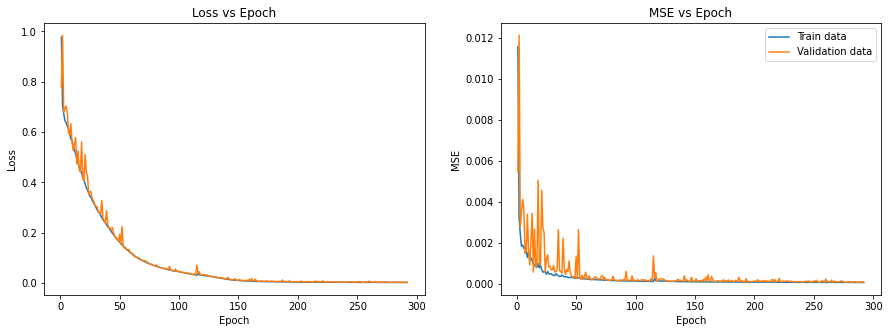

In [23]:
if PERFORM_TRAINING:
    _, axes = plot.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Loss vs Epoch plot
    _ = axes[0].plot(range(1, best_epoch_idx + 2),
                     history.history['loss'][:best_epoch_idx + 1],
                     label='Train data')
    _ = axes[0].plot(range(1, best_epoch_idx + 2),
                     history.history['val_loss'][:best_epoch_idx + 1],
                     label='Validation data')
    _ = axes[0].set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')

    # MSE vs Epoch plot
    _ = axes[1].plot(range(1, best_epoch_idx + 2),
                     history.history['mse'][:best_epoch_idx + 1],
                     label='Train data')
    _ = axes[1].plot(range(1, best_epoch_idx + 2),
                     history.history['val_mse'][:best_epoch_idx + 1],
                     label='Validation data')
    _ = axes[1].set(xlabel='Epoch', ylabel='MSE', title='MSE vs Epoch')

    _ = plot.legend()

In [24]:
# Zip model weights for download
!pushd {OUTPATH}; zip -rq test_3_weights.zip weights; popd

/content/output /content
/content


<a name="evaluation"><a/>
# Evaluation

In [25]:
def split_and_predict(x, num_batches=50):
    '''
    Utility function to do a forward pass with large data
    Splits data into batches and does forward pass through the model
    '''
    x_batches = np.array_split(x, num_batches)
    y_pred = np.concatenate([model(x_batch).numpy() for x_batch in x_batches], axis=0)[:, 0]
    return y_pred

In [26]:
# Get predictions
Y_PRED_TRAIN = split_and_predict(X_TRAIN)
Y_PRED_VAL = split_and_predict(X_VAL)

<a name="external-evaluation"><a/>
### External Evaluation

In [ ]:
# Load test data | Shape: (None, 101, 101, 1)
X_TEST, Y_TEST = None, None

In [ ]:
# Standardize test data
X_TEST = standardize(X_TEST, 'test', OUTPATH)

# Calculate MSE
test_mse = model.evaluate(X_TEST, Y_TEST, verbose=0)[1]

print(f'MSE on test data is {test_mse}')

In [ ]:
# Get predictions (needed to plot ROC curve)
Y_PRED_TEST = split_and_predict(X_TEST)

<a name="acknowledgements"></a>

# Acknowledgements

The structure of the model used was partially inspired from the paper titled:

[Deep Convolutional Neural Networks as strong gravitational lens detectors](https://arxiv.org/pdf/1705.07132.pdf) by C. Schaefer, M. Geiger, T. Kuntzer, J-P. Kneib